In [69]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import seaborn as sns 

### Data preprocess

In [70]:
def split_title(title_data):
    title_1 = title_data.split(',')[1]
    title_2 = title_1.split('.')[0].strip()
    return title_2

def status(status_data):
    title, parch = status_data
    if (title=="Master"): 
        return 1 
    elif (title=="Miss") & (parch!=0): 
        return 1
    else: 
        return 0

def child_adult(person):
    sex, age = person
    if age<=14: 
        return 'child'
    else: 
        return sex

In [71]:
def train_preprocess(path): 
    df = pd.read_csv(path)
    
    # Fill in NaN in Age column
    df['Title'] = df.Name.apply(split_title)
    child_mean = int(df[(df.Title=="Master")|(df.Title=="Miss") & (df.Parch!=0)].agg({'Age':'mean'}).round())
    adult_mean = df.groupby(['Pclass','Sex'])['Age'].transform('mean')
    df['Status'] = df[['Title', 'Parch']].apply(status, axis=1)
    df['Age'].fillna((adult_mean).where(cond = df.Status==0, other = child_mean), inplace = True)
    df['Person'] = df[['Sex', 'Age']].apply(child_adult, axis=1)
    
    # Fill in NaN in Embarked and Fare columns
    df['Embarked'].fillna(df['Embarked'].mode()[0], inplace = True)
    fare_na = df.groupby(['Pclass'])['Fare'].transform('mean')
    df['Fare'].fillna(fare_na, inplace = True)
    
    # Check if there are any NaN left
    is_null = df.isnull().sum()
    assert is_null.drop(['Cabin']).sum()==0
    return df

In [72]:
train_df = train_preprocess('train.csv')
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Status,Person
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,0,male
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,0,female
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,0,female
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs,0,female
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr,0,male


### Exploratory Data Analysis

Number of passengers (male, female and children) in each Class

Text(0.5, 1.0, 'Number of passengers in each Class')

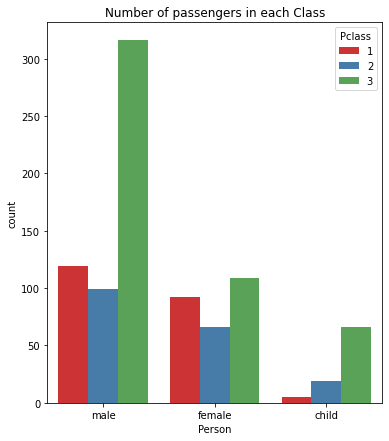

In [73]:
plt.figure(figsize = (6,7))
sns.countplot(x='Person', hue='Pclass', data=train_df, palette='Set1')
plt.title('Number of passengers in each Class')

Survival rate

<AxesSubplot:title={'center':'Survival rate, Class&Sex'}, xlabel='Person', ylabel='Survived'>

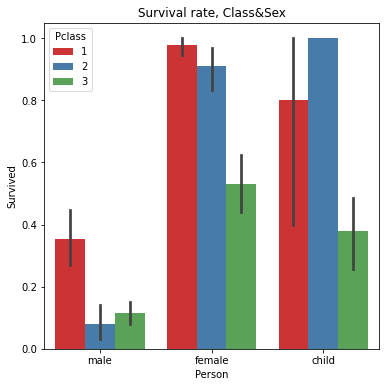

In [74]:
plt.figure(figsize=(6,6))
plt.title("Survival rate, Class&Sex")
sns.barplot(x=train_df['Person'], y=train_df['Survived'], hue=train_df['Pclass'], palette='Set1')

Count of Passengers Embarked in Each City

Text(0.5, 1.0, 'Count of Passengers Embarked in Each City by Class')

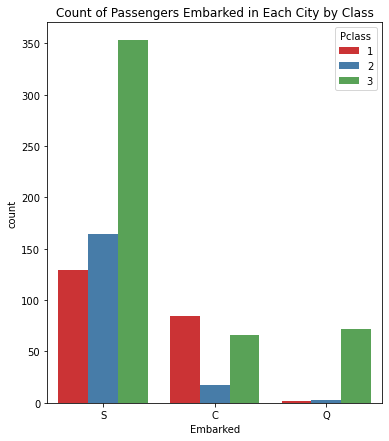

In [75]:
plt.figure(figsize=(6,7))
sns.countplot(x='Embarked',data=train_df, hue='Pclass', palette='Set1')
plt.title("Count of Passengers Embarked in Each City by Class")

Text(0.5, 1.0, 'Count of Passengers Embarked in Each City by Sex')

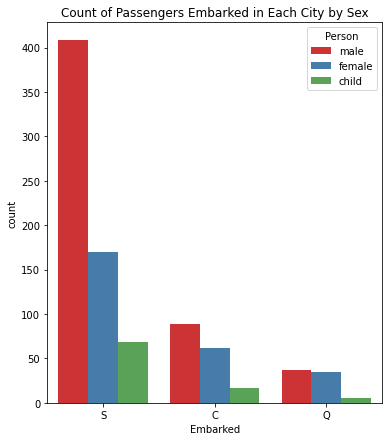

In [76]:
plt.figure(figsize=(6,7))
sns.countplot(x='Embarked',data=train_df, hue='Person', palette='Set1')
plt.title("Count of Passengers Embarked in Each City by Sex")

Survived passengers by age

Text(0.5, 1.0, 'Age of survived passengers')

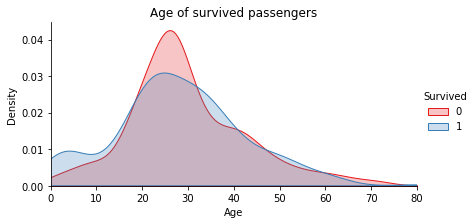

In [77]:
a = sns.FacetGrid(train_df, hue = 'Survived', aspect=2, palette='Set1')
a.map(sns.kdeplot, 'Age', shade= True )
a.set(xlim=(0 , train_df['Age'].max()))
a.add_legend()
plt.title('Age of survived passengers')

Number of Males and Females in each age group

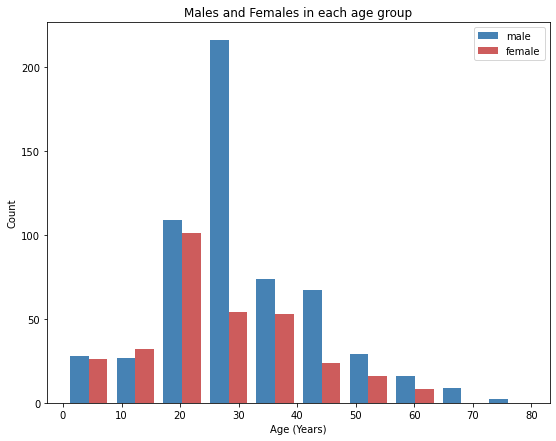

In [78]:
plt.figure(figsize=(9,7))
plt.hist(x = [train_df[train_df['Sex']=='male']['Age'], train_df[train_df['Sex']=='female']['Age']], label = ['male','female'], color = ('steelblue', 'indianred'))
plt.title('Males and Females in each age group')
plt.xlabel('Age (Years)')
plt.ylabel('Count')
plt.legend()

### Random Forest classifier

Preprocess our data again, convert categorical values

In [107]:
def preprocess(path): 
    df = pd.read_csv(path)
    
    # Fill in NaN in Age column
    df['Title'] = df.Name.apply(split_title)
    child_mean = int(df[(df.Title=="Master")|(df.Title=="Miss") & (df.Parch!=0)].agg({'Age':'mean'}).round())
    adult_mean = df.groupby(['Pclass','Sex'])['Age'].transform('mean')
    df['Status'] = df[['Title', 'Parch']].apply(status, axis=1)
    df['Age'].fillna((adult_mean).where(cond = df.Status==0, other = child_mean), inplace = True)
    
    # Fill in NaN in Embarked and Fare columns
    df['Embarked'].fillna(df['Embarked'].mode()[0], inplace = True)
    fare_na = df.groupby(['Pclass'])['Fare'].transform('mean')
    df['Fare'].fillna(fare_na, inplace = True)
    df = df.drop(['Name','Cabin', 'Ticket', 'Title','Status'], axis=1)
    
    # Check if there are any NaN left
    is_null = df.isnull().sum()
    assert is_null.sum()==0
    
    # Converting categorical values to numeric
    df['Embarked'].replace(to_replace=['S', 'C', 'Q'], value=[0, 1, 2], inplace=True)
    df['Sex'].replace(to_replace=['male', 'female'], value=[0, 1], inplace=True)
    return df

In [108]:
train = preprocess('train.csv')

In [109]:
train.set_index('PassengerId', inplace=True, drop=True)
train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
PassengerId,,,,,,,,
1,0,3,0,22.0,1,0,7.2500,0
2,1,1,1,38.0,1,0,71.2833,1
3,1,3,1,26.0,0,0,7.9250,0
4,1,1,1,35.0,1,0,53.1000,0
5,0,3,0,35.0,0,0,8.0500,0


In [120]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, recall_score, plot_roc_curve, plot_confusion_matrix, \
    plot_precision_recall_curve

In [110]:
X = train.drop(['Survived', 'Pclass'], axis=1)
y = train.Survived

In [111]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Choosing best parameters

In [115]:
clf_rf = RandomForestClassifier()
parametrs = {'n_estimators': [20,30,35,40], 'max_depth': range(2, 10)}
grid_search_cv_clf = GridSearchCV(clf_rf, parametrs, cv=5)
grid_search_cv_clf.fit(X_train, y_train)
grid_search_cv_clf.best_params_

{'max_depth': 7, 'n_estimators': 35}

In [116]:
best_clf = grid_search_cv_clf.best_estimator_
best_clf

RandomForestClassifier(max_depth=7, n_estimators=35)

In [117]:
best_clf.score(X_test, y_test)

0.8044692737430168

Making prediction

In [118]:
y_pred = best_clf.predict(X_test)

In [121]:
precision_score = precision_score(y_test, y_pred)
precision_score

0.7910447761194029

In [122]:
recall_score = recall_score(y_test, y_pred)
recall_score

0.7162162162162162

In [123]:
F1 = 2 * (precision_score * recall_score) / (precision_score + recall_score)
F1

0.7517730496453902

Confusion matrix and Feature importance

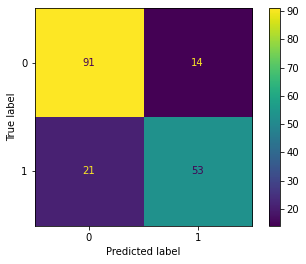

In [128]:
plot_confusion_matrix(best_clf, X_test, y_test)

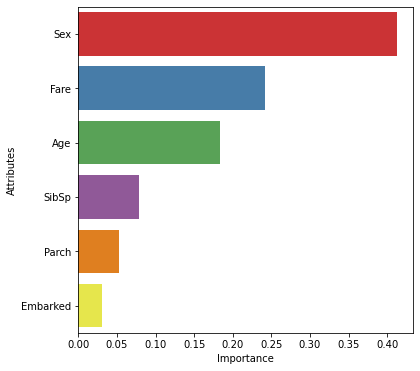

In [129]:
feature_importances_df = pd.DataFrame({'features':list(X_train.columns), 
                                       'feature_importances':  best_clf.feature_importances_})\
                        .sort_values(by='feature_importances', ascending=False)
f, ax = plt.subplots(figsize=(6, 6))
sns.barplot(y=feature_importances_df.features, x=feature_importances_df.feature_importances, palette='Set1')

plt.xlabel('Importance')
plt.ylabel('Attributes')
plt.show()

### Test data prediction

In [130]:
test = preprocess('test.csv')

In [131]:
test.set_index('PassengerId', inplace=True, drop=True)
test.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
PassengerId,,,,,,,
892,3,0,34.5,0,0,7.8292,2
893,3,1,47.0,1,0,7.0000,0
894,2,0,62.0,0,0,9.6875,2
895,3,0,27.0,0,0,8.6625,0
896,3,1,22.0,1,1,12.2875,0


In [132]:
test = test.drop(['Pclass'], axis=1)

In [133]:
y_hat_rf = best_clf.predict(test)
y_hat_rf

array([0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0,
       0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

Submission file with predicted results

In [134]:
submission = pd.read_csv("gender_submission.csv")
submission.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [136]:
submission['Survived'] = y_hat_rf
submission.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


In [137]:
submission.to_csv('submission_rfc.csv', index=False)